# Tutorial 1: Bayesian Neural Networks with Pyro



**Filled notebook:** 
- Latest version (V04/23): [![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/13bR9Po_waACHykw2eKmwt2mEmkc_BA_V)  

**Empty notebook**:
- Latest version (V04/23): this notebook

Visit also the DL2 tutorial [Github repo](https://github.com/phlippe/uvadlc_notebooks) and associated [Docs page](https://uvadlc-notebooks.readthedocs.io/en/latest/).

**Authors:**
Ilze Amanda Auzina, Leonard Bereska, Alexander Timans and Eric Nalisnick

-------------------------------------------------

## Bayesian Neural Networks

A Bayesian neural network is a probabilistic model that allows us to estimate uncertainty in predictions by representing the weights and biases of the network as probability distributions rather than fixed values. This allows us to *incorporate prior knowledge* about the weights and biases into the model, and *update our beliefs* about them as we observe data.

Mathematically, a Bayesian neural network can be represented as follows:

Given a set of input data $x$, we want to predict the corresponding output $y$. The neural network represents this relationship as a function $f(x, \theta)$, where $\theta$ are the weights and biases of the network. In a Bayesian neural network, we represent the weights and biases as probability distributions, so $f(x, \theta)$ becomes a probability distribution over possible outputs:

$$ p(y|x, \mathcal{D}) = \int p(y|x, \theta)p(\theta|\mathcal{D}) d\theta $$

where $p(y|x, \theta)$ is the likelihood function, which gives the probability of observing $y$ given $x$ and $\theta$, and $p(\theta|\mathcal{D})$ is the posterior distribution over the weights and biases given the observed data $\mathcal{D}$.

To make predictions, we use the posterior predictive distribution:

$$ p(y^*|x^*, \mathcal{D}) = \int p(y^*|x^*, \theta)p(\theta|\mathcal{D}) d\theta $$

where $x^*$ is a new input and $y^*$ is the corresponding predicted output.

To estimate the (intractable) posterior distribution $p(\theta|\mathcal{D})$, we can use either Markov Chain Monte Carlo (MCMC) or Variational Inference (VI).

## Simulate data
Let's generate noisy observations from a sinusoidal function.

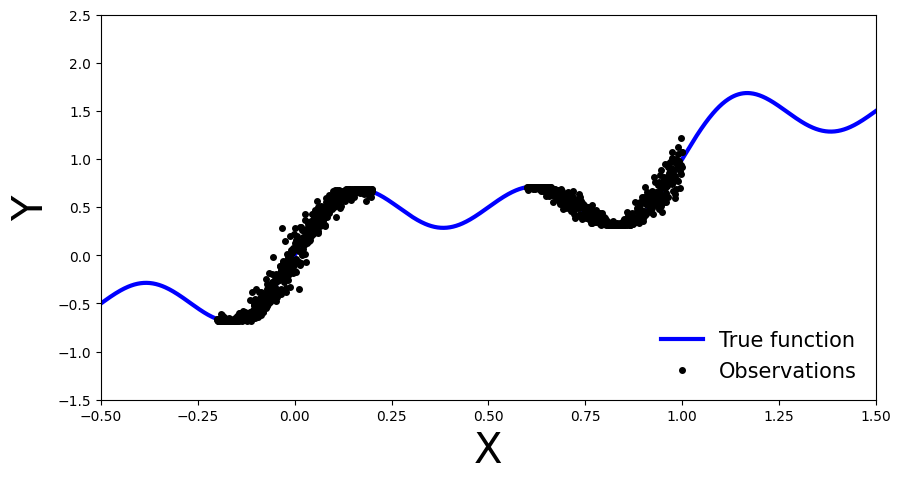

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

## Getting started with Pyro

Let's install Pyro now.  You may have to restart the runtime after this step.

In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 32.3 MB/s eta 0:00:00


## Bayesian Neural Network with Gaussian Prior and Likelihood
Our first Bayesian neural network employs a Gaussian prior on the weights and a Gaussian likelihood function for the data. The network is a shallow neural network with one hidden layer.

To be specific, we use the following prior on the weights $\theta$:

$p(\theta) = \mathcal{N}(\mathbf{0}, 10\cdot\mathbb{I}),$ where $\mathbb{I}$ is the identity matrix.

To train the network, we define a likelihood function comparing the predicted outputs of the network with the actual data points:

$p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\theta}(x_i), \sigma^2\big)$, with prior $\sigma \sim \Gamma(1,1)$.

Here, $y_i$ represents the actual output for the $i$-th data point, $x_i$ represents the input for that data point, $\sigma$ is the standard deviation parameter for the normal distribution and $NN_{\theta}$ is the shallow neural network parameterized by $\theta$. 

Note that we use $\sigma^2$ instead of $\sigma$ in the likelihood function because we use a Gaussian prior on $\sigma$ when performing variational inference and then want to avoid negative values for the standard deviation.

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

## Define and run Markov chain Monte Carlo sampler

To begin with, we can use MCMC to compute an *unbiased estimate* of $p(y|x, \mathcal{D}) = \mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big]$ through Monte Carlo sampling. Specifically, we can approximate $\mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big]$ as follows:
$$\mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big] \approx \frac{1}{N} \sum_{i=1}^{N} p(y|x,\theta_{i}),$$
where $\theta_{i} \sim p(\theta_i|\mathcal{D}) \propto p(\mathcal{D}|\theta)p(\theta)$ are samples drawn from the posterior distribution. Because the normalizing constant is intractable, we require MCMC methods like Hamiltonian Monte Carlo to draw samples from the non-normalized posterior.

Here, we use the No-U-Turn ([NUTS](https://arxiv.org/abs/1111.4246)) kernel.

In [ ]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [05:28,  3.29s/it, step size=3.40e-04, acc. prob=0.959]


We calculate and plot the predictive distribution.

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [ ]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

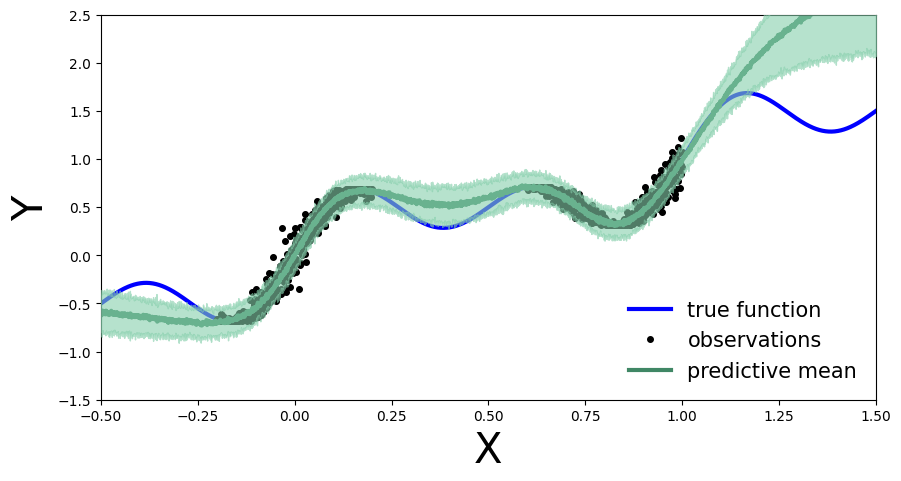

In [ ]:
plot_predictions(preds)

## Exercise 1: Deep Bayesian Neural Network

We can define a deep Bayesian neural network in a similar fashion, with Gaussian priors on the weights: 

$p(\theta) = \mathcal{N}(\mathbf{0}, 5\cdot\mathbb{I})$. 

The likelihood function is also Gaussian: 

$p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\theta}(x_i), \sigma^2\big)$, with $\sigma \sim \Gamma(0.5,1)$.

> Implement the deep Bayesian neural network and run MCMC to obtain posterior samples.
> Compute and plot the predictive distribution.
> Use the following network architecture: Number of hidden layers: 5, Number of hidden units per layer: 10, Activation function: Tanh, Prior scale: 5.

In [ ]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # TODO - define the layer sizes and the PyroModule layer list
        self.layers = NotImplemented

        # TODO - define the prior distribution over the weights and biases
        for layer_idx, layer in enumerate(self.layers):
            layer.weight = NotImplemented
            layer.bias = NotImplemented

    def forward(self, x, y=None):
        mu = NotImplemented  # TODO - compute the mean of the output distribution
        # TODO - sample the response noise
        # TODO - sample the response
        return mu

### Train the deep BNN with MCMC...

In [ ]:
# define model and data
model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train, y_train)

Compute predictive distribution...

In [ ]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)
plot_predictions(preds)

## Train BNNs with mean-field variational inference

We will now move on to variational inference. Since the normalized posterior probability density $p(\theta|\mathcal{D})$ is intractable, we approximate it with a tractable parametrized density $q_{\phi}(\theta)$ in a family of probability densities $\mathcal{Q}$. The variational parameters are denoted by $\phi$ and the variational density is called the "guide" in Pyro. The goal is to find the variational probability density that best approximates the posterior by minimizing the KL divergence $$KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big)$$ with respect to the variational parameters.
However, directly minimizing the KL divergence is not tractable because we assume that the posterior density is intractable. To solve this, we use Bayes theorem to obtain
$$
\log p(\mathcal{D}|\theta) = KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big) + ELBO(q_{\phi}(\theta)),
$$
where $ELBO(q_{\phi}(\theta))$ is the *Evidence Lower Bound*, given by
$$
ELBO(q_{\phi}(\theta)) = \mathbb{E}_{\theta \sim q_{\phi}(\theta)}\big[\log p(y|x,\theta) \big] - KL\big(q_{\phi}(\theta) || p(\theta) \big).
$$
By maximizing the ELBO, we indirectly minimize the KL divergence between the variational probability density and the posterior density.

Set up for stochastic variational inference with the variational density $q_{\phi}(\theta)$ by using a normal probability density with a diagonal covariance matrix:

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

As before, we compute the predictive distribution sampling from the trained variational density.

In [ ]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)
plot_predictions(preds)

## Exercise 2: Bayesian updating with variational inference

What happens if we obtain new data points, denoted as $\mathcal{D}'$, after performing variational inference using the observations $\mathcal{D}$?

In [ ]:
# Generate new observations
x_new = np.linspace(0.2, 0.6, 100)
noise = 0.02 * np.random.randn(x_new.shape[0])
y_new = x_new + 0.3 * np.sin(2 * np.pi * (x_new + noise)) + 0.3 * np.sin(4 * np.pi * (x_new + noise)) + noise

# Generate true function
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set axis limits and labels
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

# Plot all datasets
plt.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
plt.plot(x_new, y_new, 'ko', markersize=4, label="New observations", c="r")
plt.plot(x_obs, y_obs, 'ko', markersize=4, label="Old observations")
plt.legend(loc=4, fontsize=15, frameon=False)
plt.show()

## Bayesian update

How can we perform a Bayesian update on the model using variational inference when new observations become available?

We can use the previously calculated posterior probability density as the new prior and update the posterior with the new observations. Specifically, the updated posterior probability density is given by:

$$
p(\theta|\mathcal{D}') = \frac{p(\mathcal{D}'|\theta)q_{\phi}(\theta)}{\int p(\mathcal{D}'|\theta)q_{\phi}(\theta)}
$$

Note that we want to update our model using only the new observations $\mathcal{D}'$, relying on the fact that the variational density used as our new prior carries the necessary information on the old observations $\mathcal{D}$.


### Implementation in Pyro

To implement this in Pyro, we can extract the variational parameters (mean and standard deviation) from the `guide` and use them to initialize the prior in a new model that is similar to the original model used for variational inference.

From the Gaussian `guide` we can extract the variational parameters (mean and standard deviation) as:

```python
mu = guide.get_posterior().mean
sigma = guide.get_posterior().stddev
```





### Exercise 2.1 Learn a model on the old observations
First, as before, we define a model using Gaussian prior $\mathcal{N}(\mathbf{0}, 10\cdot \mathbb{I})$.

> Train a model `MyFirstBNN` on the old observations $\mathcal{D}$ using variational inference with `AutoDiagonalNormal()` as guide.

In [ ]:
from pyro.optim import Adam
pyro.set_rng_seed(42)
pyro.clear_param_store()

model = MyFirstBNN()
guide = NotImplemented  # TODO: Use AutoDiagonalNormal
# TODO: Learn the model using stochastic variational inference

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=5000)
preds = predictive(x_test)
plot_predictions(preds)

Next, we can extract the variational parameters (mean and standard deviation) from the `guide` and use them to initialize the prior in a new model that is similar to the original model used for variational inference.

In [ ]:
# Extract variational parameters from guide
mu = guide.get_posterior().mean.detach()
stddev = guide.get_posterior().stddev.detach()

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

### Exercise 2.2 Initialize a second model with the variational parameters
> Define a new model similar to `MyFirstBNN(PyroModule)`, that takes the variational parameters and uses them to initialize the prior.

In [ ]:
class UpdatedBNN(PyroModule):
    def __init__(self, mu, stddev, in_dim=1, out_dim=1, hid_dim=5):
        super().__init__()
        self.mu = mu
        self.stddev = stddev

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)

        self.layer1.weight = NotImplemented  # TODO: Initialize from mu and stddev
        self.layer1.bias =  NotImplemented  # TODO: Initialize from mu and stddev
        self.layer2.weight = NotImplemented  # TODO: Initialize from mu and stddev
        self.layer2.bias = NotImplemented  # TODO: Initialize from mu and stddev
        # 17th parameter is parameter sigma from the Gamma distribution

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

### Exercise 2.3 Perform variational inference on the new model
> Then perform variational inference on this new model using the new observations and plot the predictive distribution.
> What do you observe? How does the predictive distribution compare to the one obtained in Exercise 2.1?

In [ ]:
x_train_new = torch.from_numpy(x_new).float()
y_train_new = torch.from_numpy(y_new).float()

pyro.clear_param_store()

# TODO: Initialize the new model with the variational parameters
new_model = NotImplemented
new_guide = NotImplemented

# TODO: Perform variational inference on the new model

In [ ]:
predictive = Predictive(new_model, guide=new_guide, num_samples=5000)
preds = predictive(x_test)
plot_predictions(preds)